<a href="https://colab.research.google.com/github/Vakhranev/MDB/blob/main/%D0%93%D0%B5%D0%B9%D0%BC%D1%81-%D0%A5%D0%B0%D1%83%D1%8D%D0%BB%D0%BB%20%D0%B4%D0%BB%D1%8F%20%D0%BA%D0%BE%D0%BB%D0%B8%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0%20%D1%83%D0%BD%D0%B8%D0%BA%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D1%85%20%D1%82%D0%BE%D0%BA%D0%B5%D0%BD%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import glob
import re
import pymorphy2
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy import stats

# Создаем экземпляр морфологического анализатора pymorphy2
morph_analyzer = pymorphy2.MorphAnalyzer()

# Путь к папке с уровнями CEFR
cefr_levels = ["A1", "A2", "B1", "B2"]

# Список для хранения данных
data = []

# Список для хранения количества уникальных слов во всех файлах
all_unique_word_counts = []

# Обработка каждого уровня CEFR
for cefr_level in cefr_levels:
    folder_path = f"/content/Students_texts/{cefr_level}"
    file_list = glob.glob(os.path.join(folder_path, "*.txt"))

    unique_word_counts = []

    # Обработка каждого файла в текущем уровне CEFR
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()

            # Удаление тегов типа моя
            text = re.sub(r'<[^>]+>', '', text)

            # Удаление [unclear]
            text = text.replace('[unclear]', '')

            # Разделение текста на слова
            words = re.findall(r'\b\w+\b', text)

            # Список для хранения уникальных слов
            unique_words = set()

            # Обработка каждого слова
            for word in words:
                # Пропускаем пустые слова
                if not word.strip():
                    continue

                # Получаем нормальную форму слова и его грамматические признаки
                parsed_word = morph_analyzer.parse(word.lower())[0]
                normal_form = parsed_word.normal_form
                grammatical_features = parsed_word.tag.__str__()

                # Формируем строку из нормальной формы слова и его грамматических признаков
                word_info = f"{normal_form} {grammatical_features}"

                # Добавляем слово в список уникальных слов
                unique_words.add(word_info)

            # Количество уникальных слов в файле
            unique_word_count = len(unique_words)
            unique_word_counts.append(unique_word_count)
            all_unique_word_counts.extend(unique_words)

    # Сохранение данных для анализа
    data.extend(list(zip([cefr_level] * len(file_list), unique_word_counts)))

# Вычисление статистик для количества уникальных слов во всех файлах
mean_unique_word_count = np.mean(unique_word_counts)
sd_unique_word_count = np.std(unique_word_counts)
std_error_unique_word_count = stats.sem(unique_word_counts)
ci_unique_word_count = stats.t.interval(0.95, len(unique_word_counts)-1, loc=mean_unique_word_count, scale=std_error_unique_word_count)

# Вывод статистик для количества уникальных слов во всех файлах
print("Статистики для количества уникальных слов во всех файлах:")
print(f"Mean: {mean_unique_word_count}")
print(f"SD: {sd_unique_word_count}")
print(f"Std. Error: {std_error_unique_word_count}")
print(f"95% CI (confidence interval) (mean): {ci_unique_word_count}\n")

# Создаем DataFrame
df = pd.DataFrame(data, columns=['CEFR Level', 'Unique Word Count'])

# Проверка на наличие ненулевой вариабельности
if df['Unique Word Count'].nunique() <= 1:
    print("Ошибка: Недостаточная вариабельность в данных.")
else:
    # ANOVA
    anova_result = pg.anova(data=df, dv='Unique Word Count', between='CEFR Level')

    # Тест Геймса-Хауэлла
    games_howell_result = pg.pairwise_gameshowell(data=df, dv='Unique Word Count', between='CEFR Level')

    # Вывод результатов
    print(f"F-статистика (ANOVA): {anova_result['F'][0]}")
    print(f"p-value (ANOVA): {anova_result['p-unc'][0]}")

    print("\nGames-Howell Test Results:")
    print(games_howell_result)

Статистики для количества уникальных слов во всех файлах:
Mean: 164.40944881889763
SD: 47.54730000211868
Std. Error: 4.235850149382953
95% CI (confidence interval) (mean): (156.0268258989296, 172.79207173886567)

F-статистика (ANOVA): 161.30694218475344
p-value (ANOVA): 1.47481455130725e-86

Games-Howell Test Results:
    A   B     mean(A)     mean(B)        diff        se          T  \
0  A1  A2   38.888889   86.301370  -47.412481  3.428439 -13.829174   
1  A1  B1   38.888889  123.104478  -84.215589  3.540526 -23.786177   
2  A1  B2   38.888889  164.409449 -125.520560  5.028524 -24.961709   
3  A2  B1   86.301370  123.104478  -36.803108  3.098751 -11.876754   
4  A2  B2   86.301370  164.409449  -78.108079  4.727895 -16.520689   
5  B1  B2  123.104478  164.409449  -41.304971  4.809795  -8.587679   

           df          pval    hedges  
0  151.105326  1.110223e-16 -1.131903  
1  169.432781  0.000000e+00 -1.791236  
2  186.691120  5.329071e-14 -3.050353  
3  902.994877  4.185541e-13 -

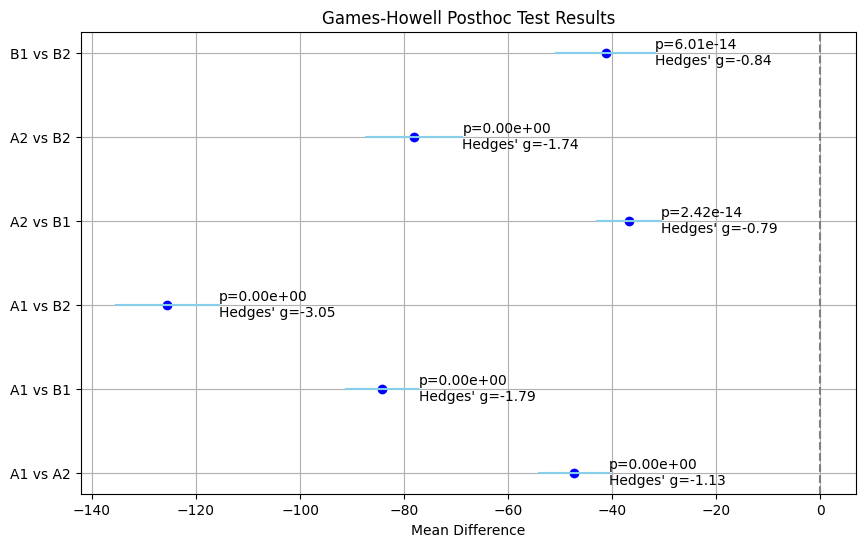

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg

# Результаты теста Геймса-Хауэла
games_howell_result = pd.DataFrame({
    'A': ['A1', 'A1', 'A1', 'A2', 'A2', 'B1'],
    'B': ['A2', 'B1', 'B2', 'B1', 'B2', 'B2'],
    'mean(A)': [38.888889, 38.888889, 38.888889, 86.301370, 86.301370, 123.104478],
    'mean(B)': [86.301370, 123.104478, 164.409449, 123.104478, 164.409449, 164.409449],
    'diff': [-47.412481, -84.215589, -125.520560, -36.803108, -78.108079, -41.304971],
    'se': [3.428439, 3.540526, 5.028524, 3.098751, 4.727895, 4.809795],
    'T': [-13.829174, -23.786177, -24.961709, -11.876754, -16.520689, -8.587679],
    'df': [151.105326, 169.432781, 186.691120, 902.994877, 192.210899, 204.848778],
    'pval': [0.000000e+00, 0.000000e+00, 0.000000e+00, 2.420286e-14, 0.000000e+00, 6.006307e-14],
    'hedges': [-1.131903, -1.791236, -3.050353, -0.785427, -1.740114, -0.841759]
})

# Расчет доверительных интервалов
z_score = 1.96
conf_intervals = [
    (md - z_score * s, md + z_score * s) for md, s in zip(games_howell_result['diff'], games_howell_result['se'])
]

# Построение графика
plt.figure(figsize=(10, 6))
for i, (group, ci, p, h) in enumerate(
    zip(games_howell_result['A'] + ' vs ' + games_howell_result['B'], conf_intervals, games_howell_result['pval'], games_howell_result['hedges'])
):
    plt.plot(ci, [i, i], color="skyblue")
    plt.scatter(games_howell_result['diff'].iloc[i], i, color="blue")
    plt.text(ci[1] + 0.05, i, f"p={p:.2e}\nHedges' g={h:.2f}", va='center')

# Элементы оформления
plt.yticks(range(len(games_howell_result)), games_howell_result['A'] + ' vs ' + games_howell_result['B'])
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel("Mean Difference")
plt.title("Games-Howell Posthoc Test Results")
plt.grid(True)
plt.show()